In [8]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [9]:
import keras
print(keras.__version__)

3.8.0


In [10]:
import numpy as np
import pandas as pd

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# reading names from text files and storing them with their origin in a DataFrame
df = pd.DataFrame(columns = ['Name', 'Origin'])
dirname = '/content/drive/My Drive/Colab Notebooks/DL/10.sequence_models/new_born/data/train'
filenames = [f for f in os.listdir(dirname) if f.endswith('.txt')]
for filename in filenames:
    file = open(f'{dirname}/{filename}', 'r')
    lines = file.readlines()
    for line in lines:
        df.loc[len(df)] = [line.strip(), filename.replace('.txt', '')]

In [13]:
df

,Name,Origin
0,Khoury,Arabic
1,Nahas,Arabic
2,Daher,Arabic
3,Gerges,Arabic
4,Nazari,Arabic
...,...,...
20069,Zdunowski,Polish
20070,Zielinski,Polish
20071,Ziemniak,Polish
20072,Zientek,Polish


In [14]:
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DL/10.sequence_models/new_born/data/test.csv')
y_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DL/10.sequence_models/new_born/data/y_test.csv')

In [15]:
# collecting all unique characters from the names and converting them to lowercase
chars = set()
for name in df['Name']:
    chars.update(name.lower())

In [16]:
# finding the length of the longest name in the dataset
longest_string = max(df['Name'].apply(len))
longest_string

20

In [17]:
chars = sorted(list(chars))

In [18]:
# encoding a word into a one-hot matrix with fixed maximum length and character set
def encode(my_word, chars = chars, max_len = longest_string):
    x = np.zeros((max_len, len(chars)))
    for i, ch in enumerate(my_word.lower()):
        if ch in chars:
            x[i, chars.index(ch)] = 1
    return x

In [19]:
# converting all names into one-hot encoded matrices and storing them in a numpy array
X = [encode(name) for name in df['Name']]
X = np.array(X)

In [22]:
# encoding test names into one-hot matrices and converting them to a numpy array
X_test = [encode(name) for name in test['Name']]
X_test = np.array(X_test)

In [23]:
# mapping language names to numeric indices and converting them to one-hot encoded labels
languages = ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']

language_to_index = {language: index for index, language in enumerate(languages)}

y_numeric = df['Origin'].map(language_to_index)

y_one_hot = np.zeros((len(y_numeric), len(languages)))

for i, label in enumerate(y_numeric):
    y_one_hot[i, label] = 1

y = y_one_hot.copy()

In [24]:
print(X.shape)
print(y.shape)

(20074, 20, 58)
(20074, 18)


In [25]:
# splitting the dataset into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1)

In [26]:
# building and compiling a GRU-based neural network model for multi-class classification
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout, Input, LSTM, BatchNormalization, GRU
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

model = Sequential()
model.add(GRU(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(18, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 256)            │       242,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,314 (966.07 KB)

 Trainable params: 247,314 (966.07 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# training the model
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=64,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 30s 97ms/step - accuracy: 0.4676 - loss: 1.9394 - val_accuracy: 0.5488 - val_loss: 1.5166
Epoch 2/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 40s 95ms/step - accuracy: 0.5522 - loss: 1.5101 - val_accuracy: 0.5553 - val_loss: 1.4474
Epoch 3/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/step - accuracy: 0.5677 - loss: 1.3959 - val_accuracy: 0.6315 - val_loss: 1.2729
Epoch 4/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 41s 93ms/step - accuracy: 0.6413 - loss: 1.2286 - val_accuracy: 0.6330 - val_loss: 1.2273
Epoch 5/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.6685 - loss: 1.1267 - val_accuracy: 0.6818 - val_loss: 1.0648
Epoch 6/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - accuracy: 0.7006 - loss: 1.0210 - val_accuracy: 0.7022 - val_loss: 1.0058
Epoch 7/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 42s 94ms/step - accuracy: 0.7287 - loss: 0.9184 - val_accuracy: 0.7321 - val_loss: 0.8899
Epoch 8/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 42s 96ms/step - accuracy: 0.7588 - loss: 0.8324 - 

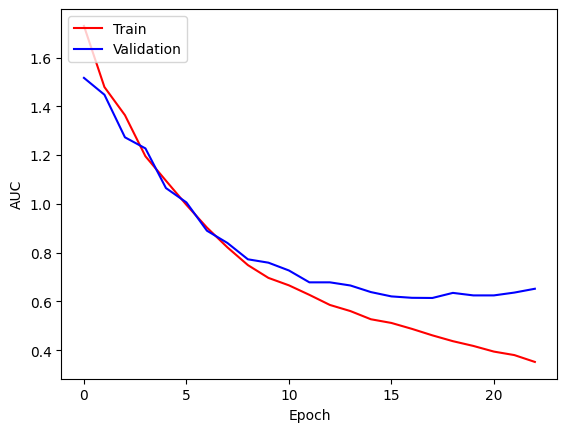

In [28]:
# plotting training and validation loss over epochs to visualize model performance
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [29]:
# evaluating the model on the training set using weighted-averaged F1 score
from sklearn.metrics import f1_score

y_train_pred_prob = model.predict(X)
y_train_pred_labels = np.argmax(y_train_pred_prob, axis=1)

y_train = np.argmax(y, axis=1)

f1 = f1_score(y_train, y_train_pred_labels, average='weighted')
print(f"F1 Score (weighted-averaged) on Training Set: {f1:.4f}")

628/628 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step
F1 Score (weighted-averaged) on Training Set: 0.8565


In [30]:
# evaluating the model on the test set using weighted-averaged F1 score
y_test_pred_prob = model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred_prob, axis = 1)

f1 = f1_score(y_test['prediction'], y_test_pred_labels, average='weighted')
print(f"F1 Score (weighted-averaged) on Test Set: {f1 * 100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
F1 Score (weighted-averaged) on Test Set: 91.64%
